# Libraries

In [2]:
import numpy as np
from random import random, seed

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter 

from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import KFold 
from sklearn import linear_model

In [3]:
def skl_standardscaler(X):
    scaler = StandardScaler(with_std=True)
    return scaler.fit(X).transform(X)
 
def create_data(N=20):
    # Make data. 
    x1 = np.linspace(0,1,N)
    y1 = np.linspace(0,1,N)
    x, y = np.meshgrid(x1,y1)

    def FrankeFunction(x,y):
        term1 = 0.75*np.exp(-(0.25*(9*x-2)**2)-0.25*((9*y-2)**2))
        term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
        term3 = 0.5*np.exp(-((9*x-7)**2)/4.0 - 0.25*((9*y-3)**2))
        term4 = -0.2*np.exp(-(9*x-4)**2-(9*y-7)**2)
        return term1+term2+term3+term4

    z = FrankeFunction(x,y)
    return x1,y1,x,y,z

def create_design_matrix(x1,y1,degree):
    power_list = [(i,j) for i in range(0,degree + 1) for j in range(0,degree + 1) if i+j <= degree]
    X = np.zeros((len(x1),len(power_list)))
    for index, (x_pow, y_pow) in enumerate(power_list):
        X[:,index] = x1**(x_pow)*y1**(y_pow)
    return X

def R2(y_data,y_model):
    return 1 - np.sum((y_data - y_model)**2)/np.sum((y_data - np.mean(y_data))**2)

def MSE(y_data, y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

def bias_variance_error(y_pred,y_test):
    error = np.mean(np.mean((y_pred-y_test)**2,axis=1,keepdims=True))
    bias = np.mean((y_test-np.mean(y_pred,axis=1,keepdims=True))**2)
    variance = np.mean(np.var(y_pred,axis=1,keepdims=True))
    return bias, variance, error

# Part a: Ordinary least square (OLS) on the Franke function

In [4]:
#---------code starts here--------------------
mse_test = []
mse_train = []
r2_train = []
r2_test = []
num_degrees = 10
alpha=0.5
for deg in range(num_degrees):
    x1,y1,x,y,z = create_data(250)
    noise = alpha*np.random.normal(size=z.shape)
    z = z + noise
    X = create_design_matrix(x1,y1,deg)

    np.random.seed(2021)
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
    #X_train = skl_standardscaler(X_train)
    #X_train[:,0] = 1
    #X_test = skl_standardscaler(X_test)
    #X_test[:,0] = 1
    
    # training and fitting
    beta_ = np.linalg.pinv(X_train.T@X_train)@X_train.T@z_train
    zpredictOwn_train = X_train @ beta_
    MSE_own_train = MSE(z_train,zpredictOwn_train)
    R2_own_train = R2(z_train,zpredictOwn_train)

    zpredictOwn_test = X_test @ beta_
    MSE_own_test = MSE(z_test,zpredictOwn_test)
    R2_own_test = R2(z_test,zpredictOwn_test)

    mse_train += [MSE_own_train]
    mse_test += [MSE_own_test]
    
    r2_train += [R2_own_train]
    r2_test += [R2_own_test]
    #print(mse_train, mse_test)

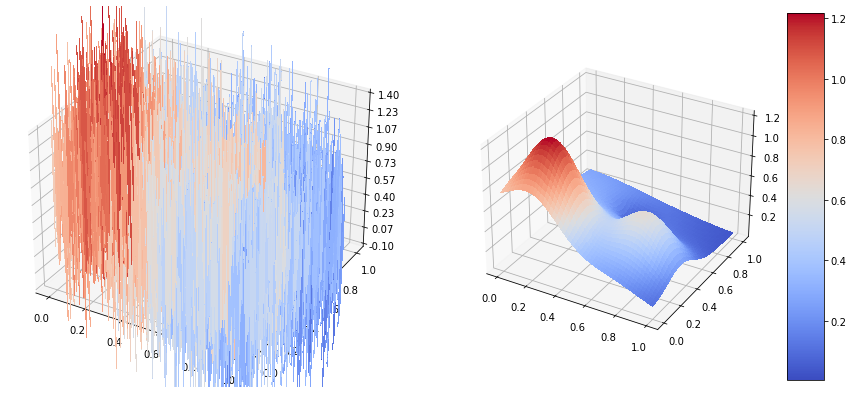

In [5]:
fig = plt.figure(figsize=(15,9))

ax = fig.add_subplot(121,projection='3d')
surf = ax.plot_surface(x,y,z,cmap=cm.coolwarm,linewidth=0,antialiased=False)

ax2 = fig.add_subplot(122,projection='3d')
surf = ax2.plot_surface(x,y,z-noise,cmap=cm.coolwarm,linewidth=0,antialiased=False)


# Customize the z axis 
ax.set_zlim(-0.10,1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color basr which maps values to colors. 
fig.colorbar(surf,shrink=0.75, aspect=10)


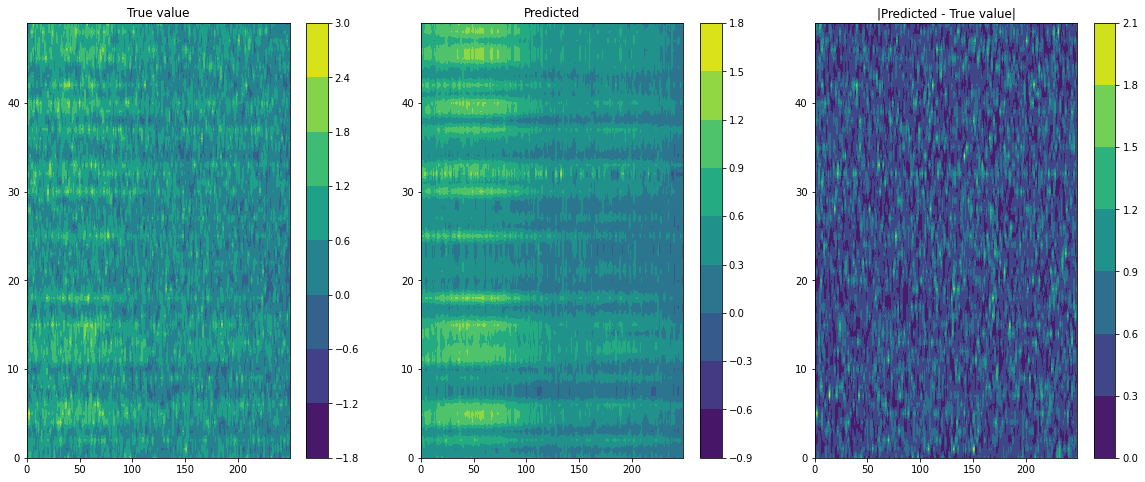

In [26]:
fig = plt.figure(figsize=(20,8))

ax2 = fig.add_subplot(131)
cs2 = ax2.contourf(z_test)
ax2.title.set_text('True value')
cbar = fig.colorbar(cs2)

ax1 = fig.add_subplot(132)
cs = ax1.contourf(zpredictOwn_test)
ax1.title.set_text('Predicted')
cbar = fig.colorbar(cs)

ax3 = fig.add_subplot(133)
cs3 = ax3.contourf(abs(z_test-zpredictOwn_test))
ax3.title.set_text('|Predicted - True value|')
cbar = fig.colorbar(cs3)

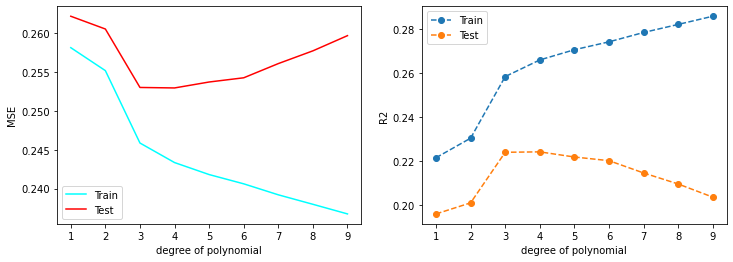

In [23]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax1.plot(range(1,num_degrees),mse_train[1:],'aqua',label="Train")
ax1.plot(range(1,num_degrees),mse_test[1:],'r',label="Test")
ax1.set_xlabel('degree of polynomial')
ax1.set_ylabel('MSE')
ax1.legend()


ax2 = fig.add_subplot(122)
ax2.plot(range(1,num_degrees),r2_train[1:],'o--',label="Train")
ax2.plot(range(1,num_degrees),r2_test[1:],'o--',label="Test")
ax2.set_xlabel('degree of polynomial')
ax2.set_ylabel('R2')
ax2.legend()

## interactive part a

In [292]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(alpha):
    #---------code starts here--------------------
    mse_test = []
    mse_train = []
    r2_train = []
    r2_test = []
    num_degrees = 10
    #alpha=0.5
    for deg in range(num_degrees):
        x1,y1,x,y,z = create_data(250)
        noise = alpha*np.random.normal(size=z.shape)
        z = z + noise
        X = create_design_matrix(x1,y1,deg)

        np.random.seed(2021)
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
        #X_train = skl_standardscaler(X_train)
        #X_train[:,0] = 1
        #X_test = skl_standardscaler(X_test)
        #X_test[:,0] = 1

        # training and fitting
        beta_ = np.linalg.pinv(X_train.T@X_train)@X_train.T@z_train
        zpredictOwn_train = X_train @ beta_
        MSE_own_train = MSE(z_train,zpredictOwn_train)
        R2_own_train = R2(z_train,zpredictOwn_train)

        zpredictOwn_test = X_test @ beta_
        MSE_own_test = MSE(z_test,zpredictOwn_test)
        R2_own_test = R2(z_test,zpredictOwn_test)

        mse_train += [MSE_own_train]
        mse_test += [MSE_own_test]

        r2_train += [R2_own_train]
        r2_test += [R2_own_test]
        #print(mse_train, mse_test)

    fig = plt.figure(figsize=(15,9))

    ax = fig.add_subplot(121,projection='3d')
    surf = ax.plot_surface(x,y,z,cmap=cm.coolwarm,linewidth=0,antialiased=False)

    ax2 = fig.add_subplot(122,projection='3d')
    surf = ax2.plot_surface(x,y,z-noise,cmap=cm.coolwarm,linewidth=0,antialiased=False)


    # Customize the z axis 
    ax.set_zlim(-0.10,1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color basr which maps values to colors. 
    fig.colorbar(surf,shrink=0.75, aspect=10)
    
    fig = plt.figure(figsize=(12,4))
    ax1 = fig.add_subplot(121)
    ax1.plot(range(1,num_degrees),mse_train[1:],'aqua',label="Train")
    ax1.plot(range(1,num_degrees),mse_test[1:],'r',label="Test")
    ax1.set_xlabel('degree of polynomial')
    ax1.set_ylabel('MSE')
    ax1.legend()


    ax2 = fig.add_subplot(122)
    ax2.plot(range(1,num_degrees),r2_train[1:],'o--',label="Train")
    ax2.plot(range(1,num_degrees),r2_test[1:],'o--',label="Test")
    ax2.set_xlabel('degree of polynomial')
    ax2.set_ylabel('R2')
    ax2.legend()
interact(f,alpha=(0,1,0.1));

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

# Part b: Bias-variance trade-off and resampling techniques

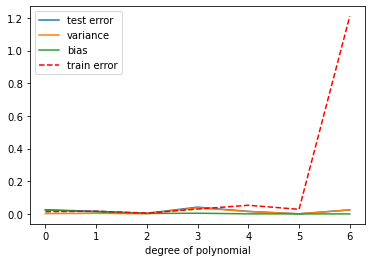

In [113]:
np.random.seed(2021)

degrees = 8
errors = []
varss = []
biass = []

errors_train = []
for deg in range(1,degrees):
    alpha = 0
    x1,y1,x,y,z = create_data(20)
    noise = alpha*np.random.normal(size=z.shape)
    z = z + noise
    X = create_design_matrix(x1,y1,deg)
    
    
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.20)
    
    # scale data
    # INSERT SCALING HERE
    #X_train = skl_standardscaler(X_train)
    #X_train[:,0] = 1
    #X_test = skl_standardscaler(X_test)
    #X_test[:,0] = 1
    
    n_bootstrap = 100
    z_pred_test = np.empty((z_test.shape[0]*z_test.shape[1],n_bootstrap))
    z_pred_train = np.empty((z_train.shape[0]*z_train.shape[1],n_bootstrap))
    
    for i in range(n_bootstrap):
        X_, z_ = resample(X_train,z_train)
        beta_= np.linalg.pinv(X_.T@X_)@X_.T@z_
        z_pred_test[:,i] = (X_test @ beta_).flatten()
        z_pred_train[:,i] = (X_train @ beta_).flatten()
        
    bias, var, error = bias_variance_error(z_pred_test,z_test.flatten().reshape(-1,1))
    _, _, error_train = bias_variance_error(z_pred_train,z_train.flatten().reshape(-1,1))
    
    errors_train.append(error_train)
    
    errors.append(error)
    varss.append(var)
    biass.append(bias)

plt.plot(errors,label="test error")
plt.plot(varss,label="variance")
plt.plot(biass,label="bias")
plt.plot(errors_train,'r--',label="train error")
#plt.ylabel('MSE')
plt.xlabel('degree of polynomial')
plt.legend()
plt.show()

In [183]:
np.random.seed(2021)

degrees = 8
errors = []
varss = []
biass = []

errors_train = []

deg = 5
alpha = 0.9
x1,y1,x,y,z = create_data(20)
noise = alpha*np.random.normal(size=z.shape)
z = z + noise
X = create_design_matrix(x1,y1,deg)

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.20)

# SCALE DATA HERE 
#X_train = skl_standardscaler(X_train)
#X_train[:,0] = 1
#X_test = skl_standardscaler(X_test)
#X_test[:,0] = 1

# DO BOOTSTRAP HERE
n_bootstrap =100
z_pred_test = np.empty((z_test.shape[0]*z_test.shape[1],n_bootstrap))
z_pred_train = np.empty((z_train.shape[0]*z_train.shape[1],n_bootstrap))

for i in range(n_bootstrap):
    X_, z_ = resample(X_train,z_train)
    beta_= np.linalg.pinv(X_.T@X_)@X_.T@z_
    z_pred_test[:,i] = (X_test @ beta_).flatten()
    z_pred_train[:,i] = (X_train @ beta_).flatten()

bias, var, error = bias_variance_error(z_pred_test,z_test.flatten().reshape(-1,1))
_, _, error_train = bias_variance_error(z_pred_train,z_train.flatten().reshape(-1,1))

errors_train.append(error_train)

errors.append(error)
varss.append(var)
biass.append(bias)

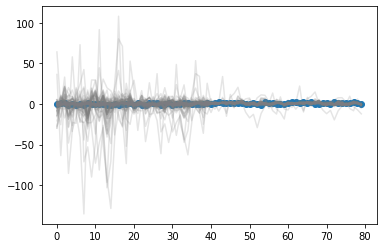

In [185]:
plt.plot(z_test.flatten(),'o--',label="Test data")

for i in range(n_bootstrap):
    plt.plot(z_pred_test[:,i],'gray',alpha=0.2)

In [186]:
import pandas as pd
df = pd.DataFrame(z_pred_train)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2.062692,190.241015,1.572398,1.876951,2.060779,-11.334394,1.867981,1.978575,2.024669,2.140872,...,2.125950,1.897141,-2.834950,1.657017,1.678842,1.806923,-6.377896,2.049093,1.326934,1.537981
1,1.407836,1.466322,1.876538,1.607077,1.436879,10.531080,1.673324,1.423125,1.391693,1.401610,...,1.418668,1.529191,5.163564,1.735515,1.658892,1.797404,1.037915,1.444118,1.977895,1.811766
2,0.452420,150.882098,0.664590,0.720339,0.446498,-5.179252,0.614568,0.442701,0.473497,0.573768,...,0.488562,0.676513,2.520804,0.452019,0.621291,0.705390,-2.392999,0.541332,0.741727,0.763039
3,0.135048,38.371424,0.123929,0.083996,0.125552,3.282517,0.004184,0.156145,0.030558,0.088820,...,0.116915,0.047471,-1.263846,0.150625,0.182897,0.005737,-5.028319,0.198816,-0.161461,0.002652
4,1.293203,181.773926,1.140895,1.267586,1.325550,-7.784201,1.295712,1.290230,1.254372,1.431720,...,1.356077,1.085065,-1.335245,1.390280,1.269867,1.443183,-13.834958,1.122527,0.861629,0.878643


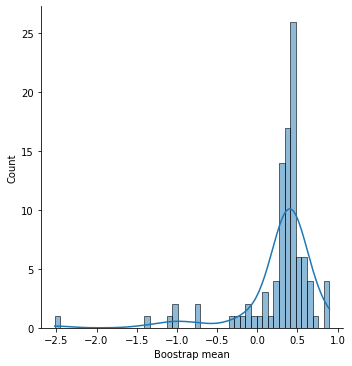

In [187]:
# on each column get the variance then get the mean of the variance
import seaborn as sns
#fig = plt.figure(figsize=(10,6))
g = sns.displot(df.mean(axis=0),kde=True)
g.set_axis_labels('Boostrap mean','Count')

In [188]:
np.mean(z_test)

0.5185488942064708

# Part c: Cross-validation as resampling techniques, adding more complexity

In [300]:
#np.random.seed(2021)

num_degrees = 8
kfold_num = 5 
kfold=KFold(n_splits=kfold_num)



mse_test = []
mse_train = []
r2_train = []
r2_test = []

MSE_kfold = []
MSE_kfold_test = []
R2_kfold = []
R2_kfold_test = []
MSE_cv = []
MSE_cv_test = []

R2_cv = []
R2_cv_test = []
#for deg in range(num_degrees):
deg = 10
x1,y1,x,y,z = create_data(20)
noise = alpha*np.random.normal(size=z.shape)
z = z + noise
X = create_design_matrix(x1,y1,deg)

# insert scaler here 

for train_inds, test_inds in kfold.split(X):
    X_train = X[train_inds]
    z_train = z[train_inds]
    X_test = X[test_inds]
    z_test = z[test_inds]

    # using the equation 
    beta_ = np.linalg.pinv(X_train.T@X_train)@X_train.T@z_train
    zpredictOwn_train = X_train @ beta_
    zpredictOwn_test = X_test @ beta_ 

    MSE_kfold += [MSE(z_train,zpredictOwn_train)]
    MSE_kfold_test += [MSE(z_test,zpredictOwn_test)]
    R2_kfold += [R2(z_train,zpredictOwn_train)]
    R2_kfold_test += [R2(z_test,zpredictOwn_test)]
    #plt.plot(MSE_kfold)
    
    #plt.plot(MSE_kfold)
MSE_cv += [np.mean(MSE_kfold)]
MSE_cv_test += [np.mean(MSE_kfold_test)]
R2_cv += [np.mean(R2_kfold)]
R2_cv_test += [np.mean(R2_kfold_test)]

In [301]:
np.random.seed(2021)

num_degrees = 8
kfold_num = 10 
kfold=KFold(n_splits=kfold_num)


def ols_cv(alpha=0):
    mse_test = []
    mse_train = []
    r2_train = []
    r2_test = []

    MSE_kfold = []
    MSE_kfold_test = []
    R2_kfold = []
    R2_kfold_test = []
    MSE_cv = []
    MSE_cv_test = []

    R2_cv = []
    R2_cv_test = []
    for deg in range(num_degrees):
        x1,y1,x,y,z = create_data(20)
        noise = alpha*np.random.normal(size=z.shape)
        z = z + noise
        X = create_design_matrix(x1,y1,deg)

        # insert scaler here 

        for train_inds, test_inds in kfold.split(X):
            X_train = X[train_inds]
            z_train = z[train_inds]
            X_test = X[test_inds]
            z_test = z[test_inds]

            # using the equation 
            beta_ = np.linalg.pinv(X_train.T@X_train)@X_train.T@z_train
            zpredictOwn_train = X_train @ beta_
            zpredictOwn_test = X_test @ beta_ 

            MSE_kfold += [MSE(z_train,zpredictOwn_train)]
            MSE_kfold_test += [MSE(z_test,zpredictOwn_test)]
            R2_kfold += [R2(z_train,zpredictOwn_train)]
            R2_kfold_test += [R2(z_test,zpredictOwn_test)]

        MSE_cv += [np.mean(MSE_kfold)]
        MSE_cv_test += [np.mean(MSE_kfold_test)]
        R2_cv += [np.mean(R2_kfold)]
        R2_cv_test += [np.mean(R2_kfold_test)]
    return R2_cv, R2_cv_test, MSE_cv, MSE_cv_test


In [302]:
def ols_cv_interactive_mse(alpha):
    R2_cv, R2_cv_test , _, _ = ols_cv(alpha)
    plt.plot(R2_cv,'o--',label="Train")
    plt.plot(R2_cv_test,'o--',label="Test")
    plt.ylabel('R2')
    plt.xlabel('degree of polynomial')
    plt.legend()
    plt.show()

interact(ols_cv_interactive,alpha=(0,1,0.1));

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

In [303]:
def ols_cv_interactive_mse(alpha):
    alpha = 0.1
    _, _ , MSE_cv, MSE_cv_test = ols_cv(alpha)
    plt.plot(MSE_cv,'o--',label="Train")
    plt.plot(MSE_cv_test,'o--',label="Test")
    plt.ylabel('MSE')
    plt.xlabel('degree of polynomial')
    plt.legend()
    plt.show()
    
interact(ols_cv_interactive_mse,alpha=(0,1,0.1));

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

In [304]:
# get R2 for each alpha 
alphas = np.arange(0,1,0.25)
r2_per_alpha = []
r2_per_alpha_test = []

for alpha in alphas:
    a, b, _, _ = ols_cv(alpha)
    r2_per_alpha.append(a)
    r2_per_alpha_test.append(b)

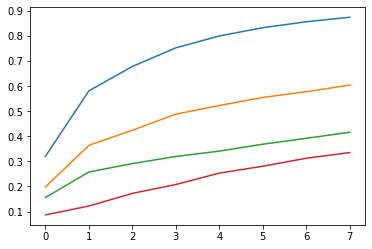

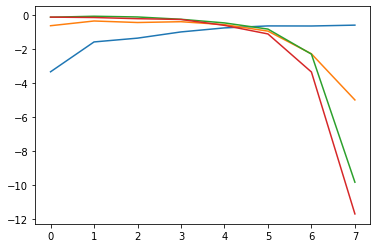

In [305]:
for r2 in r2_per_alpha:
    plt.plot(r2)
plt.show()
    
for r2 in r2_per_alpha_test:
    plt.plot(r2)
plt.show()

## Compare code with the one provided by scikit-learn

# Part d: Ridge regression on the Franke function with resampling

## w/o sampling

Ridge:
Lambda:  0.001


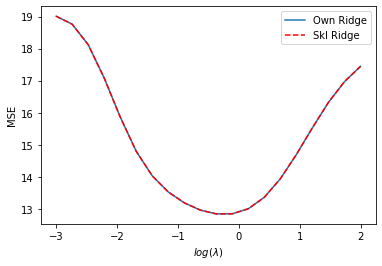

In [322]:
def skl_ridge_train_predict(X_train,z_train,X_test,z_test,lmb):
    # Make the fit using Ridge only
    RegRidge = linear_model.Ridge(lmb,fit_intercept=False)
    RegRidge.fit(X_train,z_train)
    return RegRidge.predict(X_test)

def own_ridge_train_predict(X_train,z_train,X_test,z_test,lmb):
    # Make the fit using Ridge only
    p = (X_train.T @ X_train).shape
    I = np.eye(p[0],p[1])
    Ridgebeta = np.linalg.pinv(X_train.T @ X_train+lmb*I) @ X_train.T @ z_train
    ztildeRidge = X_train @ Ridgebeta
    zpredictRidge = X_test @ Ridgebeta
    return ztildeRidge, zpredictRidge


np.random.seed(2021)
x1,y1,x,y,z = create_data(20)
noise = alpha*np.random.normal(size=z.shape)
z = z + noise
X = create_design_matrix(x1,y1,deg)

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.20)

# SCALE DATA HERE 
#X_train = skl_standardscaler(X_train)
#X_train[:,0] = 1
#X_test = skl_standardscaler(X_test)
#X_test[:,0] = 1


print('Ridge:')
nlambdas = 20
lambdas = np.logspace(-3, 2, nlambdas)
print('Lambda: ',lambdas[0])

# scikit Ridge
mse_test_skl = np.zeros(nlambdas)
for i, lmb in enumerate(lambdas):
    z_ridge = skl_ridge_train_predict(X_train, z_train, X_test, z_test,lmb)#lambdas[0])
    mse_test_skl[i] = np.sum((z_test - z_ridge)**2)/len(z_test)
    # own Ridge

# own ridge
mse_test = np.zeros(nlambdas)
for i, lmb in enumerate(lambdas):
    ztilde, zpredict = own_ridge_train_predict(X_train, z_train, X_test, z_test,lmb)
    mse_test[i] = np.sum((z_test - zpredict)**2)/len(z_test)

plt.plot(np.log10(lambdas),mse_test,label="Own Ridge")
plt.plot(np.log10(lambdas),mse_test_skl,'r--',label="Skl Ridge")
plt.xlabel("$log(\lambda)$")
plt.ylabel("MSE")
plt.legend()
plt.show()

## w/ sampling - boostrap

In [271]:
np.random.seed(2021)

degrees = 10

nlambdas = 10
lambdas = np.logspace(-3, 2, nlambdas)

var_record = np.zeros((degrees,nlambdas))
bias_record = np.zeros((degrees,nlambdas))
lmb = lambdas[0]

#for i, lmb in enumerate(lambdas):
errors = []
varss = []
biass = []
for deg in range(degrees):
    alpha = 0.1
    x1,y1,x,y,z = create_data(20)
    noise = alpha*np.random.normal(size=z.shape)
    z = z + noise
    X = create_design_matrix(x1,y1,deg)

    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.20)

    # INSERT SCALER HERE!
    #X_train = skl_standardscaler(X_train)
    #X_train[:,0] = 1
    #X_test = skl_standardscaler(X_test)
    #X_test[:,0] = 1

    n_bootstrap = 100
    z_pred = np.empty((z_test.shape[0]*z_test.shape[1],n_bootstrap))


    for i in range(n_bootstrap):
        X_, z_ = resample(X_train,z_train)
        p = (X_.T @ X_).shape
        I = np.eye(p[0],p[1])
        Ridgebeta = np.linalg.pinv(X_.T @ X_+lmb*I) @ X_.T @ z_
        z_pred[:,i] = ( X_test @ Ridgebeta).flatten()

    bias, var, error = bias_variance_error(z_pred,z_test.flatten().reshape(-1,1))

    errors.append(error)
    varss.append(var)
    biass.append(bias)

#var_record[:,i] = varss
#bias_record[:,i] = biass

#plt.plot(errors,label="error")
#plt.plot(varss,label="variance")
#plt.plot(biass,label="bias")
#plt.legend()
#plt.show()

In [272]:
df_ridge = pd.DataFrame(z_pred)
df_ridge.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.399602,0.330297,0.454560,0.441975,0.460237,0.355235,0.380334,0.426335,0.453982,0.461251,...,0.406998,0.357630,0.336839,0.442667,0.414139,0.485645,0.440917,0.458190,0.431370,0.399461
1,0.425230,0.333203,0.485583,0.429071,0.493953,0.439499,0.476633,0.480586,0.430476,0.451944,...,0.457626,0.397641,0.376883,0.496088,0.466289,0.445307,0.461566,0.457852,0.473225,0.446699
2,0.334501,0.285443,0.350118,0.325435,0.367659,0.334710,0.301822,0.404233,0.281712,0.309878,...,0.343049,0.401786,0.422494,0.383186,0.369751,0.305580,0.340366,0.330134,0.364276,0.397087
3,0.389887,0.136046,0.496493,0.405298,0.515765,0.320743,0.536999,0.557230,0.351461,0.455451,...,0.443027,0.425040,0.441768,0.584165,0.547742,0.427053,0.489570,0.446846,0.477783,0.454368
4,0.401419,0.269318,0.390882,0.411376,0.435674,0.405863,0.474426,0.465794,0.376872,0.422971,...,0.449400,0.465385,0.485896,0.459512,0.457324,0.369453,0.419545,0.426923,0.447208,0.485795


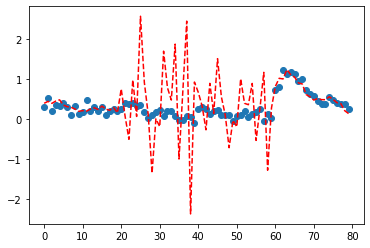

In [273]:
plt.plot(z_test.flatten(),'o',label="Test data")
plt.plot(z_pred[:,-1],'r--')

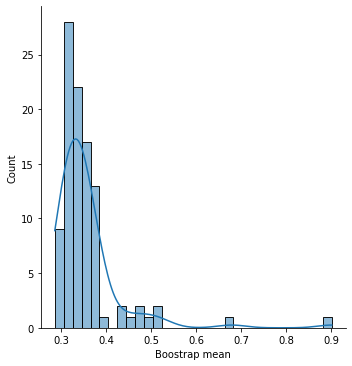

In [274]:
# on each column get the variance then get the mean of the variance
import seaborn as sns
#fig = plt.figure(figsize=(10,6))
g = sns.displot(df_ridge.mean(axis=0),kde=True)
g.set_axis_labels('Boostrap mean','Count')

In [182]:
np.mean(z_test.flatten())

0.32039124049702805

## w/ sampling - cross validation

In [268]:
np.random.seed(2021)

num_degrees = 5
kfold_num = 5 

#for k in range(5,kfold_num):
mse_test = []
mse_train = []
r2_train = []
r2_test = []

kfold=KFold(n_splits=kfold_num)

nlambdas = 10
lambdas = np.logspace(-3, 2, nlambdas)
lmb = lambdas[1]

mse_record = np.zeros((num_degrees-1,nlambdas))
r2_record = np.zeros((num_degrees-1,nlambdas))
for i, lmb in enumerate(lambdas):
    MSE_kfold = []
    R2_kfold = []
    MSE_cv_ridge = []
    R2_cv_ridge = []
    
    MSE_kfold_test = []
    R2_kfold_test = []
    MSE_cv_ridge_test = []
    R2_cv_ridge_test = []
    for deg in range(1,num_degrees):
        x1,y1,x,y,z = create_data(20)
        noise = alpha*np.random.normal(size=z.shape)
        z = z + noise
        X = create_design_matrix(x1,y1,deg)
        
        #X_scaled = skl_standardscaler(X)
        #X_scaled[:,0] = 1

        for train_inds, test_inds in kfold.split(X):
            X_train = X[train_inds]
            z_train = z[train_inds]
            X_test = X[test_inds]
            z_test = z[test_inds]

            # using the equation 
            #beta_ = np.linalg.pinv(X_train.T@X_train)@X_train.T@z_train
            #zpredictOwn_train = X_train @ beta_
            p = (X_train.T @ X_train).shape
            I = np.eye(p[0],p[1])
            Ridgebeta = np.linalg.pinv(X_train.T @ X_train+lmb*I) @ X_train.T @ z_train
            
            zpredictOwn_train =  X_train @ Ridgebeta
            MSE_kfold += [MSE(z_train,zpredictOwn_train)]
            R2_kfold += [R2(z_train,zpredictOwn_train)]
            
            zpredictOwn_test = X_test @ Ridgebeta
            MSE_kfold_test += [MSE(z_test,zpredictOwn_test)]
            R2_kfold_test += [R2(z_test,zpredictOwn_test)]
            
        MSE_cv_ridge += [np.mean(MSE_kfold)]
        R2_cv_ridge += [np.mean(R2_kfold)]
        
        MSE_cv_ridge_test += [np.mean(MSE_kfold_test)]
        R2_cv_ridge_test += [np.mean(R2_kfold_test)]
        
    #print(len(MSE_cv_ridge_test))
    mse_record[:,i] = MSE_cv_ridge_test
    r2_record[:,i] = R2_cv_ridge_test
    #import matplotlib.pyplot as plt
    #f, (ax1, ax2) = plt.subplots(1, 1, sharey=True)
    #plt.plot(z_train.flatten(),label="True value - train")
    #plt.plot(zpredictOwn_train.flatten(), label="Ridge: $\lambda=$"+str(lmb))
    #plt.legend()

    # ax2.plot(z_test.flatten(),label="True value - train")
    # ax2.plot(zpredictOwn_test.flatten(), label="Ridge: $\lambda=$"+str(lmb))
    # ax2.legend()
    plt.show()

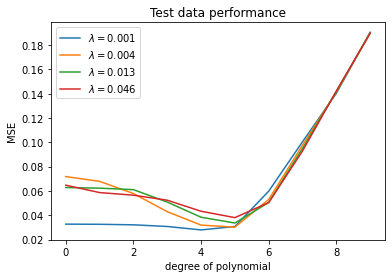

In [269]:
for i, mse_plt in enumerate(mse_record):
    plt.plot(mse_plt,label="$\lambda=$"+str(round(lambdas[i],3)))
plt.title('Test data performance')
plt.ylabel('MSE')
plt.xlabel('degree of polynomial')
plt.legend()

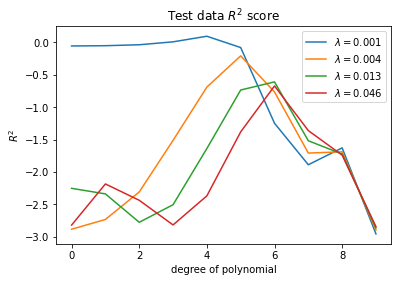

In [270]:
for i,r2_plt in enumerate(r2_record):
    plt.plot(r2_plt,label="$\lambda=$"+str(round(lambdas[i],3)))
plt.title('Test data $R^2$ score',)
plt.ylabel('$R^2$')
plt.xlabel('degree of polynomial')
plt.legend()

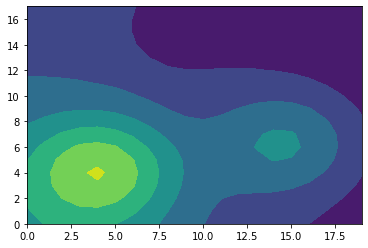

In [266]:
#f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
plt.contourf(z_train)

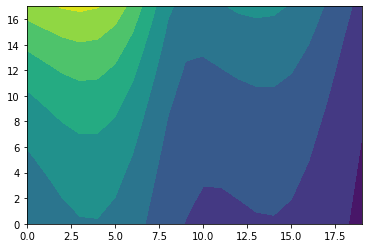

In [267]:
plt.contourf(zpredictOwn_train)

# Part e: Lasso Regression on the Franke function with resampling

In [196]:
def skl_lasso_train_predict(X_train,z_train,X_test,z_test,lmb):
    # Make the fit using Lasso only
    RegLasso = linear_model.Lasso(lmb,fit_intercept=False,tol=1e-2)
    RegLasso.fit(X_train,z_train)
    return RegLasso.predict(X_test)

## w/o sampling 

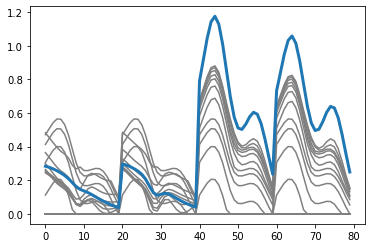

In [244]:
np.random.seed(2021)
x1,y1,x,y,z = create_data(20)
alpha = 0.0
noise = alpha*np.random.normal(size=z.shape)
z = z + noise
X = create_design_matrix(x1,y1,deg)


X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.20)

# scale data
# X_train = skl_standardscaler(X_train)
# X_train[:,0] = 1
# X_test = skl_standardscaler(X_test)
# X_test[:,0] = 1
    
nlambdas = 20
lambdas = np.logspace(-3, 2, nlambdas)
lmb = lambdas[1]

for lmb in lambdas:
    zpred_lasso = skl_lasso_train_predict(X_train,z_train,X_test,z_test,lmb)
    plt.plot(zpred_lasso.flatten(),'gray',label='Lasso: $\lambda$='+str(round(lmb,3)))
plt.plot(z_test.flatten(),linewidth=3,label="Test Value")
#plt.legend()
plt.show()

## w/ sampling - bootstrap

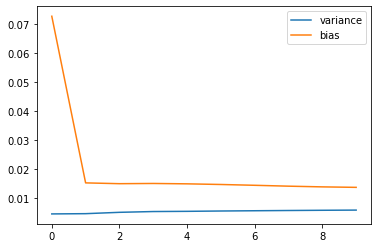

In [213]:
nlambdas = 10
lambdas = np.logspace(-3, 2, nlambdas)
lmb = lambdas[2]

#for lmb in lambdas:
degrees = 10
errors = []
varss = []
biass = []
for deg in range(num_degrees):
    x1,y1,x,y,z = create_data(20)
    alpha = 0
    noise = alpha*np.random.normal(size=z.shape)
    z = z + noise
    X = create_design_matrix(x1,y1,deg)

    X_scaled = skl_standardscaler(X)
    X_scaled[:,0] = 1
    np.random.seed(2021)
    X_train, X_test, z_train, z_test = train_test_split(X_scaled, z, test_size=0.33)

    # scale data
    #X_train = skl_standardscaler(X_train)
    #X_train[:,0] = 1
    #X_test = skl_standardscaler(X_test)
    #X_test[:,0] = 1

    n_bootstrap = 500
    z_pred = np.empty((z_test.shape[0]*z_test.shape[1],n_bootstrap))


    for i in range(n_bootstrap):
        X_, z_ = resample(X_train,z_train)
        lasso_predict = skl_lasso_train_predict(X_,z_,X_test,z_test,lmb)
        z_pred[:,i] = lasso_predict.flatten()

    bias, var, error = bias_variance_error(z_pred,z_test.flatten().reshape(-1,1))

    errors.append(error)
    varss.append(var)
    biass.append(bias)

#plt.plot(errors,label="error")
plt.plot(varss,label="variance")
plt.plot(biass,label="bias")
plt.legend()
#plt.show()

In [236]:
print(X_test.shape)
print(z_test.shape)

(7, 55)
(7, 20)


Text(0, 0.5, 'z')

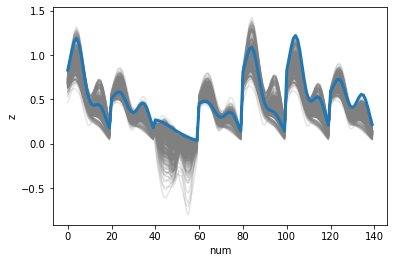

In [227]:
for i in range(n_bootstrap):
    plt.plot(z_pred[:,i],'gray',label="Prediction: bootstrap n="+str(i),alpha=0.2)
plt.plot(z_test.flatten(),linewidth=3,label="Test data")
plt.xlabel('num')
plt.ylabel('z')

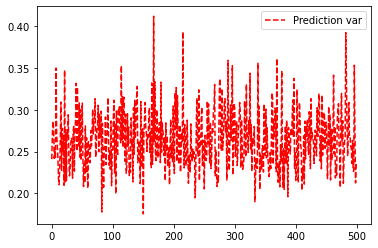

In [215]:
import pandas as pd
df_lasso = pd.DataFrame(z_pred)
df_lasso.std()
plt.plot(df_lasso.std(),'r--',label="Prediction var")
plt.legend()

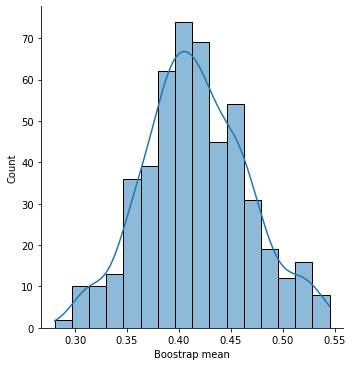

In [216]:
df_lasso = pd.DataFrame(z_pred)
df_lasso.head()

# on each column get the variance then get the mean of the variance
import seaborn as sns
#fig = plt.figure(figsize=(10,6))
g = sns.displot(df_lasso.mean(axis=0),kde=True)
g.set_axis_labels('Boostrap mean','Count')

In [212]:
np.mean(z_test.flatten())

0.4904840835774236

## w/ sampling - cross-validation

In [571]:
np.random.seed(2021)

num_degrees = 15
kfold_num = 5

#for k in range(5,kfold_num):
mse_test = []
mse_train = []
r2_train = []
r2_test = []

kfold=KFold(n_splits=kfold_num)


nlambdas = 15
lambdas = np.logspace(-3, 2, nlambdas)
lmb = lambdas[1]


MSE_kfold = []
R2_kfold = []
MSE_kfold_train = []
R2_kfold_train = []

MSE_cv_lasso = []
R2_cv_lasso = []
MSE_cv_lasso_train = []
R2_cv_lasso_train = []
for deg in range(num_degrees):
    x1,y1,x,y,z = create_data(20)
    alpha = 0.1
    noise = alpha*np.random.normal(size=z.shape)
    z = z + noise
    X = create_design_matrix(x1,y1,deg)
    
    X_scaled = skl_standardscaler(X)
    X_scaled[:,0] = 1
    
    for train_inds, test_inds in kfold.split(X_scaled):
        X_train = X[train_inds]
        z_train = z[train_inds]
        X_test = X[test_inds]
        z_test = z[test_inds]

        # using the equation 
        zpredictOwn_test = skl_lasso_train_predict(X_train,z_train,X_test,z_test,lmb)
        zpredictOwn_train = skl_lasso_train_predict(X_train,z_train,X_train,z_train,lmb)

        MSE_kfold += [MSE(z_test,zpredictOwn_test)]
        R2_kfold += [R2(z_test,zpredictOwn_test)]
        
        MSE_kfold_train += [MSE(z_train,zpredictOwn_train)]
        R2_kfold_train += [R2(z_train,zpredictOwn_train)]
        
    MSE_cv_lasso += [np.mean(MSE_kfold)]
    MSE_cv_lasso_train += [np.mean(MSE_kfold_train)]
    
    R2_cv_lasso += [np.mean(R2_kfold)]
    R2_cv_lasso_train += [np.mean(R2_kfold_train)]

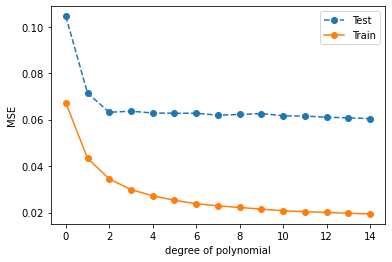

In [572]:
plt.plot(MSE_cv_lasso,'o--',label="Test")
plt.plot(MSE_cv_lasso_train,'o-',label="Train")
plt.ylabel('MSE')
plt.xlabel('degree of polynomial')
plt.legend()
plt.show()

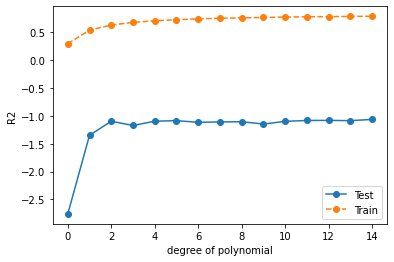

In [573]:
plt.plot(R2_cv_lasso,'o-',label="Test")
plt.plot(R2_cv_lasso_train,'o--',label="Train")
plt.ylabel('R2')
plt.xlabel('degree of polynomial')
plt.legend()
plt.show()

In [574]:
z_test.shape

(4, 20)

In [575]:
zpredictOwn_test.shape

(4, 20)

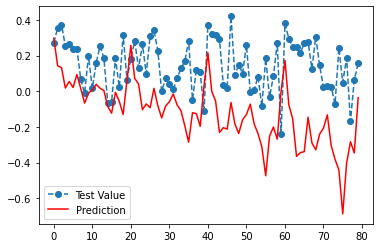

In [576]:
plt.plot(z_test.flatten(),'o--',label="Test Value")
plt.plot(zpredictOwn_test.flatten(),'r',label='Prediction')
plt.legend()
plt.show()

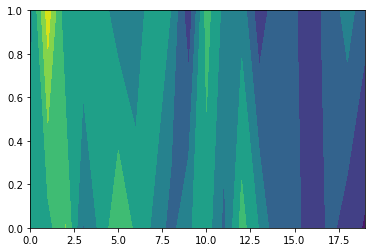

In [554]:
plt.contourf(z_test)

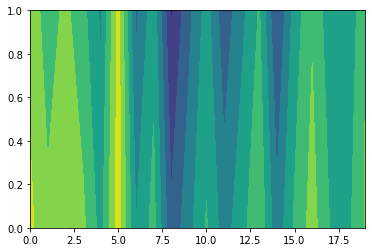

In [555]:
plt.contourf(zpredictOwn_test)